### Device Initialization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler


import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


### Data Preparation

In [2]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD  = [0.2470, 0.2435, 0.2616]


transform = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./data', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./data', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./data', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

### Training/Accuracy

In [3]:
def compute_accuracy(loader, model, device=device):
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum().item()
            num_samples += y.size(0)
    return num_correct / num_samples



In [4]:
def evaluate_model(loader, model, device=device):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [5]:
import matplotlib.pyplot as plt

def train(model, optimizer, epochs=1, print_every=100):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Tracks:
      - per-iteration training loss
      - per-iteration validation accuracy
    Allows:
      - early stop via Ctrl+C
    Plots:
      - loss vs iteration
      - validation accuracy vs iteration
    """
    model = model.to(device=device)

    history = {
        "iter": [],
        "train_loss": [],
        "val_acc": [],
    }

    global_iter = 0

    try:
        for e in range(epochs):
            print("=" * 60)
            print(f"Epoch {e + 1}/{epochs}")
            print("=" * 60)

            model.train()

            for t, (x, y) in enumerate(loader_train):
                global_iter += 1

                x = x.to(device=device, dtype=dtype)
                y = y.to(device=device, dtype=torch.long)

                scores = model(x)
                loss = F.cross_entropy(scores, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if global_iter % print_every == 0:
                    # Record train loss
                    history["iter"].append(global_iter)
                    history["train_loss"].append(loss.item())

                    # Compute validation accuracy
                    val_acc = compute_accuracy(loader_val, model)
                    history["val_acc"].append(val_acc)

                    print(f"[Iter {global_iter}] loss = {loss.item():.4f}")
                    print(f"   validation accuracy: {val_acc * 100:.2f}%")

            print()

    except KeyboardInterrupt:
        print("\n⚠️ Training interrupted by user. Plotting collected results...\n")

    finally:
        if len(history["iter"]) > 0:
            it = history["iter"]
            loss = history["train_loss"]
            acc  = [a * 100 for a in history["val_acc"]]

            plt.figure(figsize=(8, 5))

            # ---- Left axis: Loss ----
            ax1 = plt.gca()
            ax1.plot(it, loss, color='tab:red', marker='o', label='Training Loss')
            ax1.set_xlabel("Iteration")
            ax1.set_ylabel("Training Loss", color='tab:red')
            ax1.tick_params(axis='y', labelcolor='tab:red')
            
            # ---- Right axis: Accuracy ----
            ax2 = ax1.twinx()
            ax2.plot(it, acc, color='tab:blue', marker='o', label='Validation Accuracy')
            ax2.set_ylabel("Validation Accuracy (%)", color='tab:blue')
            ax2.tick_params(axis='y', labelcolor='tab:blue')

            # ---- Title & Grid ----
            plt.title("Training Loss & Validation Accuracy vs Iteration")
            ax1.grid(True)

            plt.show()

        else:
            print("No statistics collected; nothing to plot.")


    return history


In [6]:
def train_model(model, optimizer):
    train(model, optimizer, epochs=10)

### Train model here!

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

class DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()

        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = float(drop_rate)

    def bn_function(self, inputs):
        concat_features = torch.cat(inputs, 1)
        return self.conv1(self.relu1(self.norm1(concat_features)))
    
    def forward(self, inputs):
        bottleneck_output = self.bn_function(inputs)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))

        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=True)

        return new_features

class DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super().__init__()

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
            )
            self.layers.append(layer)

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_features = layer(features)
            features.append(new_features)

        return torch.cat(features, dim=1)

class DenseNet(nn.Module):
    """
    Generic DenseNet, configured for CIFAR-10 style inputs (3x32x32).
    """

    def __init__(
        self,
        growth_rate=12,
        block_config=(16, 16, 16),
        num_init_features=24,
        bn_size=4,
        drop_rate=0.0,
        num_classes=10,
    ):
        super().__init__()

        # CIFAR-10 stem: 3x3 conv, stride 1
        self.stem = nn.Sequential(
            nn.Conv2d(
                3, num_init_features,
                kernel_size=3, stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
        )

        num_features = num_init_features

        # Dense blocks + transition layers
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()

        for i, num_layers in enumerate(block_config):
            block = DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
            )
            self.blocks.append(block)
            num_features = num_features + num_layers * growth_rate

            # Add transition layer between DenseBlocks
            if i != len(block_config) - 1:
                trans = Transition(
                    num_input_features=num_features,
                    num_output_features=num_features // 2,
                )
                self.transitions.append(trans)
                num_features = num_features // 2

        # Final norm
        self.norm_final = nn.BatchNorm2d(num_features)

        # Classifier
        self.classifier = nn.Linear(num_features, num_classes)

        # (Optional) init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode="fan_out", nonlinearity="relu"
                )
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)

        for i, block in enumerate(self.blocks):
            x = block(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)

        x = self.norm_final(x)
        x = F.relu(x, inplace=True)

        # Global average pooling over H, W -> 1x1
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)

        x = self.classifier(x)
        return x



Epoch 1/10
[Iter 100] loss = 1.5083
   validation accuracy: 38.90%
[Iter 200] loss = 1.5865
   validation accuracy: 41.80%
[Iter 300] loss = 1.5420
   validation accuracy: 45.30%
[Iter 400] loss = 1.6150
   validation accuracy: 48.50%
[Iter 500] loss = 1.4770
   validation accuracy: 47.30%
[Iter 600] loss = 1.1324
   validation accuracy: 49.70%
[Iter 700] loss = 1.3712
   validation accuracy: 54.70%

Epoch 2/10
[Iter 800] loss = 1.4122
   validation accuracy: 55.10%
[Iter 900] loss = 1.2514
   validation accuracy: 56.10%
[Iter 1000] loss = 1.3153
   validation accuracy: 58.20%
[Iter 1100] loss = 1.2458
   validation accuracy: 58.50%
[Iter 1200] loss = 1.1524
   validation accuracy: 62.50%
[Iter 1300] loss = 1.1269
   validation accuracy: 60.30%
[Iter 1400] loss = 1.2881
   validation accuracy: 62.50%
[Iter 1500] loss = 0.9505
   validation accuracy: 63.90%

Epoch 3/10
[Iter 1600] loss = 1.1685
   validation accuracy: 65.00%
[Iter 1700] loss = 1.2392
   validation accuracy: 60.60%
[Iter

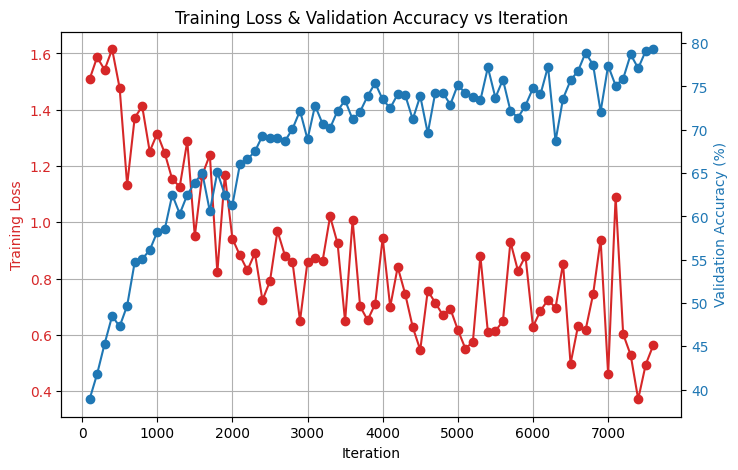

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600],
 'train_loss': [1.5082519054412842,
  1.5864702463150024,
  1.5419749021530151,
  1.6149823665618896,
  1.4770104885101318,
  1.1323742866516113,
  1.3711881637573242,
  1.4121754169464111,
  1.2513668537139893,
  1.315342664718628,
  1.2457650899887085,
  1.1524401903152466,
  1.1268668174743652,
  1.2881323099136353,
  0.9505080580711365,
  1.1685419082641602,
  1.239166259765625,
  0.82

In [8]:
model = DenseNet()             
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(model, optimizer, epochs=10)

Epoch 1/10
[Iter 100] loss = 1.5837
   validation accuracy: 37.30%
[Iter 200] loss = 1.6239
   validation accuracy: 41.80%
[Iter 300] loss = 1.6685
   validation accuracy: 46.00%
[Iter 400] loss = 1.3272
   validation accuracy: 48.60%
[Iter 500] loss = 1.5411
   validation accuracy: 52.10%
[Iter 600] loss = 1.4138
   validation accuracy: 52.60%
[Iter 700] loss = 1.3288
   validation accuracy: 58.30%

Epoch 2/10
[Iter 800] loss = 1.2716
   validation accuracy: 56.50%
[Iter 900] loss = 1.1217
   validation accuracy: 58.60%
[Iter 1000] loss = 1.1761
   validation accuracy: 53.20%
[Iter 1100] loss = 1.1037
   validation accuracy: 60.40%
[Iter 1200] loss = 0.9707
   validation accuracy: 59.90%
[Iter 1300] loss = 0.9667
   validation accuracy: 64.30%
[Iter 1400] loss = 0.7467
   validation accuracy: 60.60%
[Iter 1500] loss = 0.8710
   validation accuracy: 64.40%

Epoch 3/10
[Iter 1600] loss = 0.9244
   validation accuracy: 65.30%
[Iter 1700] loss = 0.9958
   validation accuracy: 67.50%
[Iter

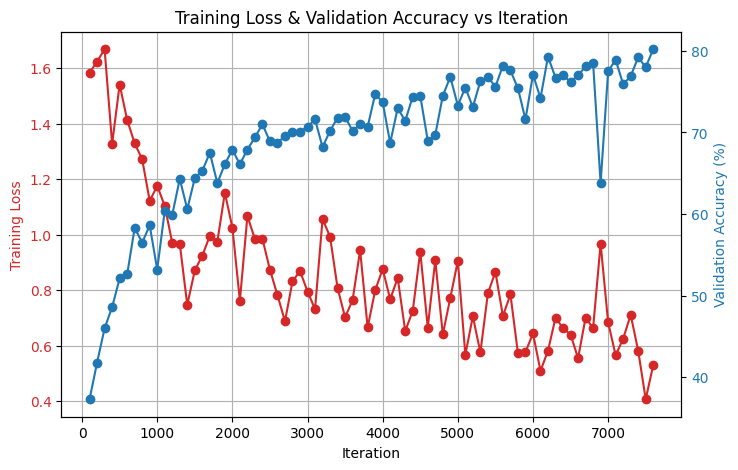

{'iter': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600],
 'train_loss': [1.5836735963821411,
  1.6239056587219238,
  1.668486475944519,
  1.3271554708480835,
  1.5411157608032227,
  1.413779616355896,
  1.3288487195968628,
  1.271622657775879,
  1.121734619140625,
  1.1760661602020264,
  1.103695273399353,
  0.9707337617874146,
  0.9667425751686096,
  0.7467319965362549,
  0.8710438013076782,
  0.9244004487991333,
  0.9957907795906067,
  0.97483

In [10]:
densenet = DenseNet(
    growth_rate=16,
    block_config=(6, 12, 8),
    num_init_features=32,
    bn_size=4,
    drop_rate=0.0,
    num_classes=10
)             
optimizer = optim.Adam(densenet.parameters(), lr=1.5e-3)

train(densenet, optimizer, epochs=10)

### Model Evaluation

In [11]:
best_model = densenet
evaluate_model(loader_test, best_model)

Checking accuracy on test set
Got 7905 / 10000 correct (79.05)
